# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [10]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(26)
torch.manual_seed(26)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## Torus model

In [12]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [13]:
sw_list = []

In [14]:
for i_round, nsamples in enumerate([2000, 2000, 4000, 15000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent, threshold = 1e-4)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Constrained posterior area: 1.0
Adding 1975 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 6
Validation losses: [5.27464035153389, 4.662165939807892, 4.55528949201107, 4.405793085694313, 4.292057305574417, 4.438082650303841]
LR iteration 1
Total epochs: 3
Validation losses: [4.288688808679581, 4.112407714128494, 4.24709914624691]
LR iteration 2
Total epochs: 2
Validation losses: [4.0793474316596985, 4.254006892442703]
Constrained posterior area: 0.12966684
Adding 1749 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 6
Validation losses: [6.489944875240326, 5.9830209612846375, 5.803736537694931, 5.727923274040222, 5.683930337429047, 5.753006041049957]
LR iteration 1
Total epochs: 3
Validation losses: [5.572364568710327, 5.56446048617363, 5.626718193292618]
LR iteration 2
Total epochs: 2
Validation losses: [5.468233346939087, 5.60424742102623]
Constrained posterior area: 0.055930413
Adding 3120 new samples. Run simulator!
Start training
LR 

In [15]:
print("Total number of samples in datastore:", len(ds))

Total number of samples in datastore: 20011


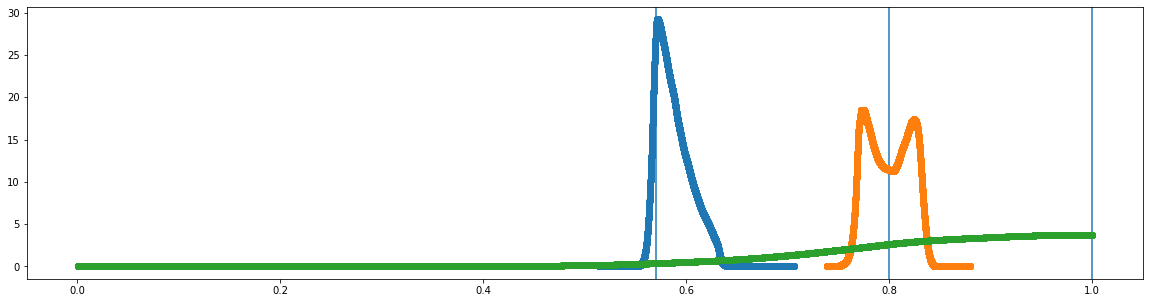

In [16]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p, marker='o')

In [17]:
sw_list[-1].trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4], tag = 'default')

Start training
LR iteration 0
Total epochs: 4
Validation losses: [4.742809623479843, 4.251179426908493, 3.9469004571437836, 4.099622130393982]
LR iteration 1
Total epochs: 2
Validation losses: [3.900647357106209, 3.9564849883317947]
LR iteration 2
Total epochs: 3
Validation losses: [3.944257616996765, 3.626213312149048, 3.859463393688202]


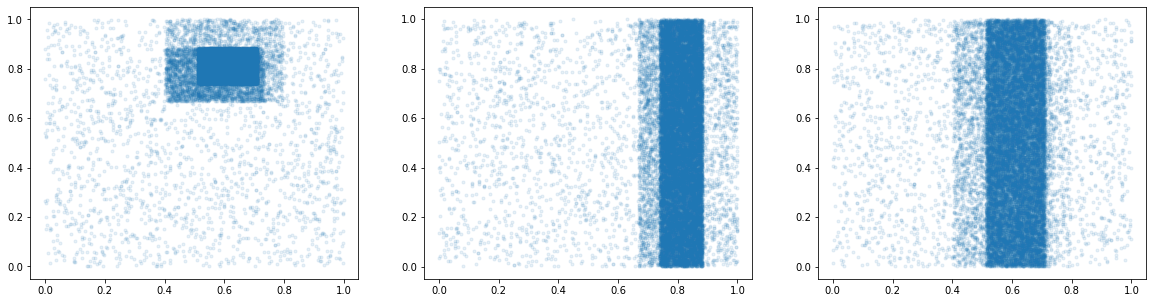

In [11]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(ds.z[:,0], ds.z[:,1], marker='.', alpha = 0.1)
plt.subplot(132)
plt.scatter(ds.z[:,1], ds.z[:,2], marker='.', alpha = 0.1)
plt.subplot(133)
plt.scatter(ds.z[:,0], ds.z[:,2], marker='.', alpha = 0.1)

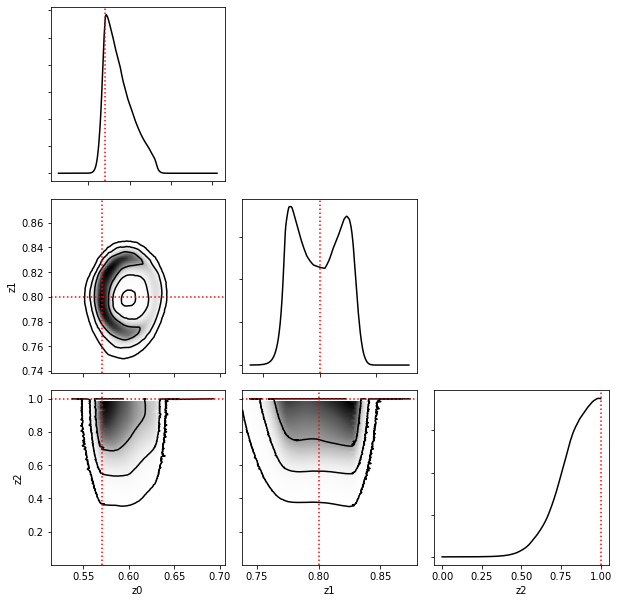

In [18]:
swyft.corner(sw_list[-1], z0 = z0, tag = 'default', cmap = 'Greys', params = [0, 1, 2], dim = 10)
#plt.savefig("corner.pdf")